In [4]:
import os
import math
import time
import tqdm
import copy
import pickle
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from medpy import metric
import cv2

import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torchmetrics.classification import StatScores

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [7]:
path_root = os.getcwd()
path_root = path_root.replace('code','')
os.chdir(path_root)

# DATA

## Exploration

In [3]:
path2train = "./data/train/"
path2val   = "./data/val/"
path2test  = "./data/test/"

imgsList_train = list(sorted(os.listdir(os.path.join(path2train, "images"))))
masksList_train = list(sorted(os.listdir(os.path.join(path2train, "masks"))))
imgsList_val = list(sorted(os.listdir(os.path.join(path2val, "images"))))
masksList_val = list(sorted(os.listdir(os.path.join(path2val, "masks"))))

print("number of images in train :", len(imgsList_train))
print("number of masks in train :", len(masksList_train))
print("number of images in val :", len(imgsList_val))
print("number of masks in val :", len(masksList_val))

number of images in train : 3173
number of masks in train : 3173
number of images in val : 496
number of masks in val : 496
number of images in test : 496
number of in test : 496


In [10]:
# Parametros
num_classes = 3

# Define transformation functions:
from albumentations import (
    ShiftScaleRotate,
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    RandomBrightnessContrast,
    Compose,
    SmallestMaxSize,
    Resize,
    RandomCrop,
    CenterCrop,
    PadIfNeeded,
    RGBShift,
    HueSaturationValue,
    Blur,
    GaussNoise,
    RandomGamma,
    OneOf,
    Lambda,
    Normalize)

c,h,w=3,320,320

transform_train = Compose([SmallestMaxSize(max_size=400,p=1),
                           OneOf([RandomCrop(h,w,p=0.5), Resize(h,w,p=0.5)],p=1),
                           HorizontalFlip(p=0.5),
                           VerticalFlip(p=0.5),
                           RandomRotate90(p=0.5),
                           ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=5, p=0.5),
                           OneOf([RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.25),
                                 RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.25),
                                 HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.25)],
                                p=0.25),
                           OneOf([Blur(p=0.25, blur_limit = 3),
                                 RandomGamma(p=0.25),
                                 GaussNoise(p=0.25)],p=0.25)])

transform_valtest = Compose( [Resize(h,w)])  

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [ Lambda(image=preprocessing_fn) ]
    return Compose(_transform)

# Class dataset
class PaCDataset(object):
    def __init__(self, root, imgsList, masksList, transforms, preprocessing):
        self.root = root
        self.transforms = transforms
        self.preprocessing = preprocessing

        self.imgs = imgsList
        self.masks = masksList
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        # apply augmentations
        if self.transforms is not None:
            augmented= self.transforms(image=np.array(img), mask=np.array(mask))
            img, mask = augmented['image'], augmented['mask']
        
        # apply preprocessing
        if self.preprocessing is not None:
            sample = self.preprocessing(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']    
        
        mask = mask//255
        target = 4*mask[:,:,0]+2*mask[:,:,1]+mask[:,:,2]
        
        # re-etiquetado: BW-0(000)/C-1(010)/P-2(100)
        target[target == 1] = 0
        target[target == 2] = 1
        target[target == 3] = 0
        target[target == 4] = 2
        target[target == 5] = 0
        target[target == 6] = 0
        target[target == 7] = 0
        
        img = to_tensor(img).type(torch.float)            
        target= torch.from_numpy(target).type(torch.long)
        return img, target

    def __len__(self):
        return len(self.imgs)

# Model: Manet + resnst296e

In [11]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['BW','C','P']
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
net = smp.MAnet(
    encoder_name=ENCODER,
    encoder_depth=5,
    encoder_weights=ENCODER_WEIGHTS,
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_pab_channels=64,
    in_channels=3,
    classes=len(CLASSES), 
    activation=ACTIVATION
)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model=net.to(device)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
# Dataset
train_ds = PaCDataset(path2train,imgsList_train,masksList_train,transforms=transform_train,preprocessing=get_preprocessing(preprocessing_fn))
val_ds = PaCDataset(path2val,imgsList_val,masksList_val,transforms=transform_valtest,preprocessing=get_preprocessing(preprocessing_fn))

# Dataloader
miniBatchSize = 8
train_dl = DataLoader(train_ds, batch_size=miniBatchSize, num_workers=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=miniBatchSize, num_workers=4, shuffle=False) 

# Setup

In [14]:
def metrics_batch(pred, target,num_classes):
    # pred (N,C,H,W) - float32
    # traget (N,H,W) - int64
    num = torch.zeros(1, num_classes).to(device)
    den = torch.zeros(1, num_classes).to(device)
    preds= F.softmax(pred,dim=1)
    stat_scores = StatScores(reduce='macro', mdmc_reduce='global',num_classes=num_classes).to(device) # (C,5) -> [tp, fp, tn, fn, sup]
    stat = stat_scores(preds, target)
    tps = stat[:,0]  # tensor([0., 0., 1.])
    fps = stat[:,1]
    fns = stat[:,3]
    #tps, fps, tns, fns, sups = stat_scores_multiple_classes(preds, target, num_classes)
    
    num += tps
    den += (tps + fps + fns)
    return num,den

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

## Loss Function

In [15]:
from torch import nn

def CV_Loss_2(input, target,device):
    # pred : (N,C,H,W) softmax likelihood
    # target : (N,H,W) class label
    target = F.one_hot(target,num_classes=input.shape[1]).permute(0,3,1,2).contiguous()
    inshape = input.shape
    tarshape = target.shape
    eps = torch.tensor([1/20]).to(device)
    
    phi = input - 0.5
    H_phi = 0.5*(1+torch.tanh(phi/eps))
    
    """
    Chan-Vesse region term
    """
    c_1 = torch.sum(target*H_phi,(2,3))/(torch.sum(H_phi,(2,3))+ 0.00000001) # [200, 3]
    C_1 = c_1.view(tarshape[0], inshape[1], 1, 1).expand(tarshape[0], inshape[1], tarshape[2], tarshape[3]) # [220, 3, 256, 256]
    c_2 = torch.sum(target  * (1 - H_phi),(2,3))/(torch.sum(1 - H_phi,(2,3))+ 0.00000001) # [200, 3]
    C_2 = c_2.view(tarshape[0], inshape[1], 1, 1).expand(tarshape[0], inshape[1], tarshape[2], tarshape[3])

    region_in_cv = torch.abs(torch.mean( H_phi * ((target - C_1)**2) ) ) # equ.(12) in the paper
    region_out_cv = torch.abs(torch.mean( (1-H_phi) * ((target - C_2)**2) )) # equ.(12) in the paper
    
    lambda_1 = 1 # lambda parameter could be various.
    lambda_2 = 1 # lambda parameter could be various.

    return lambda_1*region_in_cv + lambda_2*region_out_cv

def loss_func(pred, target):
    ce = nn.CrossEntropyLoss(reduction="mean")
    loss_ce = ce(pred, target) # incluye softmax
    pred = F.softmax(pred,dim=1)
    loss_cv = CV_Loss_2(pred, target,device)
    a = 0.1
    c = 10
    loss = a*loss_ce + c*loss_cv
    return loss

def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)*miniBatchSize
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item()

# Train

In [17]:
def loss_epoch(model,loss_func,dataset_dl,num_classes,opt=None):
    running_loss=0.0
    running_num=torch.zeros(1, num_classes).to(device)
    running_den=torch.zeros(1, num_classes).to(device)
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b = loss_batch(loss_func, output, yb, opt)
        num_b,den_b = metrics_batch(output, yb,num_classes)

        running_loss += loss_b
        running_num += num_b
        running_den += den_b
        
    iou = running_num.float() / running_den
    iou[iou != iou] = 0
    metric = torch.mean(iou)
    
    loss=running_loss/float(len_data)
    return loss, metric.item()


import copy
def train_val_1(model, params):
    # early stop
    epochs_no_improve = 0
    early_stop = False

    num_classes=params["num_classes"]
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    n_epochs_stop = params["n_epochs_stop"]

    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}  
      
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')  
    best_metric=0.0 
    
    for epoch in range(num_epochs):
        since = time.time()
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric =loss_epoch(model,loss_func,train_dl,num_classes,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl,num_classes)
       
        loss_history["val"].append(val_loss)  
        metric_history["val"].append(val_metric)
        
        epochs_no_improve += 1 
        
        if val_loss < best_loss:
            best_loss = val_loss
            #best_model_wts = copy.deepcopy(model.state_dict())
            path2weights_loss = path2weights + "_loss.pt"
            torch.save(model.state_dict(), path2weights_loss)
            print("Copied best model weights (loss) !")
            epochs_no_improve = 0
    
            
        if val_metric > best_metric:
            best_metric = val_metric
            best_model_wts = copy.deepcopy(model.state_dict())
            path2weights_metric = path2weights + "_metric.pt"
            torch.save(model.state_dict(), path2weights_metric)
            print("Copied best model weights (metric) !")  
            epochs_no_improve = 0
            

        lr_scheduler.step(val_loss)
        #lr_scheduler.step()
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
            
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))    
        print("train loss: %.6f, train metric: %.6f" %(train_loss, train_metric))    
        print("val loss: %.6f, val metric: %.6f" %(val_loss, val_metric))
        print("-"*10) 

        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue
        break

    #model.load_state_dict(best_model_wts)
    path2weights_last = path2weights + "_last.pt"
    torch.save(model.state_dict(), path2weights_last)
    print("Copied best model weights (last) !") 
    return model, loss_history, metric_history

# Evaluation

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

try:
    # %tensorflow_version only exists in Colab.
    import tensorflow.compat.v2 as tf
except Exception:
    pass

# Fuente: https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def safe_divide(a, b):
    """
    Avoid divide by zero
    http://stackoverflow.com/questions/26248654/numpy-return-0-with-divide-by-zero
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[c == np.inf] = 0
        c = np.nan_to_num(c)
        return c   

def metrics_cnf_mx(confusion_mat):
    true_pos = np.diagonal(confusion_mat)
    false_pos = np.sum(confusion_mat, axis=0) - true_pos
    false_neg = np.sum(confusion_mat, axis=1) - true_pos
    true_neg = np.sum(confusion_mat) - true_pos - false_pos - false_neg
    support = np.sum(confusion_mat, axis=1)

    acc  = safe_divide(true_pos, support)
    prec = safe_divide(true_pos, (true_pos + false_pos))
    rec  = safe_divide(true_pos, (true_pos + false_neg))
    fpr  = safe_divide(false_pos, (false_pos + true_neg))
    fnr  = safe_divide(false_neg, (false_neg + true_pos))
    #f1   = 2 * safe_divide((prec * rec), (prec + rec))
 
    ova_acc = np.sum(true_pos) / np.sum(support)
    avg_acc = np.mean(acc)
    #mf1     = np.mean(f1)

    iou     = safe_divide(true_pos, (true_pos + false_pos + false_neg))
    miou    = np.mean(iou)
    fwiou   = np.sum(support*true_pos / (true_pos + false_pos + false_neg)) / np.sum(support)

    dice    = safe_divide(2*true_pos, (2*true_pos + false_pos + false_neg))
    mdice   = np.mean(dice)

    print("Metricas por clase")
    print("            (    BW,     C,     P)")
    #print("Accuracy  : (%.4f, %.4f, %.4f)" % (acc[0], acc[1], acc[2]))
    print("FPR       : (%.4f, %.4f, %.4f)" % (fpr[0], fpr[1], fpr[2]))
    print("FNR       : (%.4f, %.4f, %.4f)" % (fnr[0], fnr[1], fnr[2]))
    print("Precision : (%.4f, %.4f, %.4f)" % (prec[0], prec[1], prec[2]))
    print("Recall    : (%.4f, %.4f, %.4f)" % (rec[0], rec[1], rec[2]))
    #print("F1        : (%.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f)" % (f1[0], f1[1], f1[2], f1[3], f1[4], f1[5], f1[6], f1[7]))
    print("IoU       : (%.4f, %.4f, %.4f)" % (iou[0], iou[1], iou[2]))
    print("Dice      : (%.4f, %.4f, %.4f)" % (dice[0], dice[1], dice[2]))

    print("......................................................")
    print("Metricas Globales")
    print("Overall Accuracy       : %.4f" % ova_acc)
    print("Average Accuracy (APC) : %.4f" % avg_acc)
    #print("mf1                    : %.4f" % mf1)
    print("mIoU                   : %.4f" % miou)
    print("fwIoU                  : %.4f" % fwiou)
    print("mDice                  : %.4f" % mdice)

def show_target(target):
    target = target.numpy()
    mask = np.zeros((h,w,3))
    # color
    target[target == 2] = 4
    target[target == 1] = 2
    mask[:,:,2] =  target%2
    mask[:,:,1] =  (target//2)%2
    mask[:,:,0] =  (target//2)//2
    mask = 255*np.int_(mask)
    plt.imshow(mask)
    
def re_normalize (x, mean = mean, std= std):
    x_r= x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean, std)):
        x_r [c] *= std_c
        x_r [c] += mean_c
    return x_r

def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum()>0:
        iou  = metric.binary.jc(pred, gt)
        dice = metric.binary.dc(pred, gt)
        hd = metric.binary.hd(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return iou, dice, hd, hd95, 1, 1
    elif pred.sum() == 0 and gt.sum()>0:
        return 0, 0, 0, 0, 1, 0
    else:
        return 0, 0, 0, 0, 0, 0

# CE + CV Loss

In [47]:
# create segmentation model with pretrained encoder
net = smp.Unet(
    encoder_name=ENCODER,
    encoder_depth=5,
    encoder_weights=ENCODER_WEIGHTS,
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_attention_type="scse", 
    in_channels=3,
    classes=len(CLASSES), 
    activation=ACTIVATION
)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model=net.to(device)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:
lr=1e-3
opt = optim.Adam(model.parameters(), lr=lr,  betas=(0.9, 0.999), weight_decay=0.0)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.1, patience=40,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_classes":3,
    "num_epochs": 500,
    "n_epochs_stop":60,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smp_manet_320_effb5_cecv_01",
}

model, loss_hist, metric_hist = train_val_1(model, params_train)

Epoch 0/499, current lr=0.001
Copied best model weights (loss) !
Copied best model weights (metric) !
Training complete in 1m 52s
train loss: 0.116973, train metric: 0.356250
val loss: 0.355219, val metric: 0.237251
----------
Epoch 1/499, current lr=0.001
Copied best model weights (loss) !
Copied best model weights (metric) !
Training complete in 1m 53s
train loss: 0.101668, train metric: 0.374564
val loss: 0.101112, val metric: 0.413722
----------
Epoch 2/499, current lr=0.001
Copied best model weights (loss) !
Copied best model weights (metric) !
Training complete in 1m 55s
train loss: 0.098540, train metric: 0.382339
val loss: 0.092461, val metric: 0.424649
----------
Epoch 3/499, current lr=0.001
Copied best model weights (loss) !
Copied best model weights (metric) !
Training complete in 1m 57s
train loss: 0.096938, train metric: 0.387618
val loss: 0.084324, val metric: 0.461797
----------
Epoch 4/499, current lr=0.001
Copied best model weights (loss) !
Training complete in 1m 58s

Training complete in 1m 59s
train loss: 0.064102, train metric: 0.661267
val loss: 0.064873, val metric: 0.574685
----------
Epoch 49/499, current lr=0.001
Training complete in 1m 59s
train loss: 0.065691, train metric: 0.628405
val loss: 0.066111, val metric: 0.595530
----------
Epoch 50/499, current lr=0.001
Training complete in 1m 59s
train loss: 0.063557, train metric: 0.662441
val loss: 0.060566, val metric: 0.632470
----------
Epoch 51/499, current lr=0.001
Copied best model weights (metric) !
Training complete in 1m 59s
train loss: 0.062858, train metric: 0.669027
val loss: 0.060730, val metric: 0.653224
----------
Epoch 52/499, current lr=0.001
Training complete in 1m 60s
train loss: 0.064513, train metric: 0.658699
val loss: 0.062870, val metric: 0.636848
----------
Epoch 53/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.063952, train metric: 0.661200
val loss: 0.063014, val metric: 0.610213
----------
Epoch 54/499, current lr=0.001
Training complete in 1m 58s

Training complete in 1m 58s
train loss: 0.059663, train metric: 0.688793
val loss: 0.060887, val metric: 0.637881
----------
Epoch 100/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.060483, train metric: 0.690091
val loss: 0.064592, val metric: 0.631654
----------
Epoch 101/499, current lr=0.001
Training complete in 1m 59s
train loss: 0.059659, train metric: 0.685611
val loss: 0.056938, val metric: 0.669072
----------
Epoch 102/499, current lr=0.001
Copied best model weights (metric) !
Training complete in 1m 59s
train loss: 0.059722, train metric: 0.697600
val loss: 0.058685, val metric: 0.675674
----------
Epoch 103/499, current lr=0.001
Training complete in 1m 60s
train loss: 0.058906, train metric: 0.696898
val loss: 0.057222, val metric: 0.661216
----------
Epoch 104/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.058968, train metric: 0.685820
val loss: 0.057135, val metric: 0.628798
----------
Epoch 105/499, current lr=0.001
Training complete in 

Training complete in 1m 58s
train loss: 0.056562, train metric: 0.716943
val loss: 0.057854, val metric: 0.654876
----------
Epoch 152/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.057947, train metric: 0.707570
val loss: 0.053592, val metric: 0.673861
----------
Epoch 153/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.056544, train metric: 0.712730
val loss: 0.055863, val metric: 0.659445
----------
Epoch 154/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.056703, train metric: 0.718329
val loss: 0.057742, val metric: 0.659300
----------
Epoch 155/499, current lr=0.001
Training complete in 1m 59s
train loss: 0.056315, train metric: 0.711997
val loss: 0.056069, val metric: 0.640099
----------
Epoch 156/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.056883, train metric: 0.709076
val loss: 0.055059, val metric: 0.687839
----------
Epoch 157/499, current lr=0.001
Training complete in 1m 58s
train loss: 0.056728, train me

Training complete in 1m 58s
train loss: 0.053348, train metric: 0.736670
val loss: 0.054087, val metric: 0.671370
----------
Epoch 203/499, current lr=0.0001
Training complete in 1m 58s
train loss: 0.053747, train metric: 0.734234
val loss: 0.054119, val metric: 0.678041
----------
Epoch 204/499, current lr=0.0001
Training complete in 1m 59s
train loss: 0.053454, train metric: 0.735356
val loss: 0.053724, val metric: 0.678025
----------
Epoch 205/499, current lr=0.0001
Training complete in 1m 59s
train loss: 0.053755, train metric: 0.735414
val loss: 0.054653, val metric: 0.677288
----------
Epoch 206/499, current lr=0.0001
Training complete in 1m 58s
train loss: 0.053202, train metric: 0.738127
val loss: 0.054895, val metric: 0.675131
----------
Epoch 207/499, current lr=0.0001
Training complete in 1m 59s
train loss: 0.052904, train metric: 0.743643
val loss: 0.055523, val metric: 0.674770
----------
Epoch 208/499, current lr=0.0001
Training complete in 1m 58s
train loss: 0.053327, tr

Loss (min): 
Index:  129
Loss:  0.051875273787206216
Metric:  0.6707034111022949


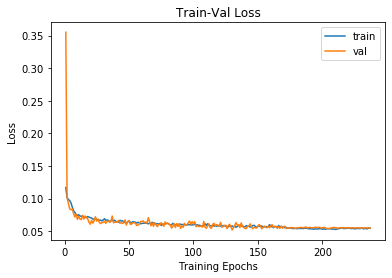

Metric (max): 
Index:  176
0.6930146217346191


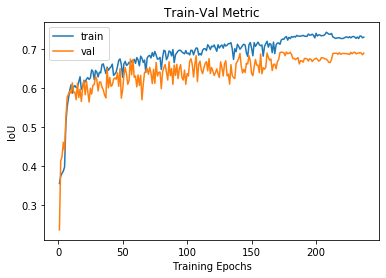

Metric (Last): 
Index:  236
Metric:  0.6900768280029297


In [16]:
with open('./models/hist_smp_manet_320_effb5_cecv_01.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump([loss_hist,metric_hist], f, pickle.HIGHEST_PROTOCOL)
    
print("Loss (min): ")
print("Index: ",loss_hist["val"].index(min(loss_hist["val"])))
print("Loss: ",min(loss_hist["val"]))
print("Metric: ",metric_hist["val"][loss_hist["val"].index(min(loss_hist["val"]))])
# plot the progress of the training and validation losses:
num_epochs = len(loss_hist["train"])
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

print("Metric (max): ")
print("Index: ",metric_hist["val"].index(max(metric_hist["val"])))
print(max(metric_hist["val"]))
plt.title("Train-Val Metric")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("IoU")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

print("Metric (Last): ")
print("Index: ",len(metric_hist["val"])-1)
print("Metric: ",metric_hist["val"][-1])

# Test

In [ ]:
path2test  = "./data/test/"

imgsList_test = list(sorted(os.listdir(os.path.join(path2test, "images"))))
masksList_test = list(sorted(os.listdir(os.path.join(path2test, "masks"))))

print("number of images in test :", len(imgsList_test))
print("number of in test :", len(masksList_test))

In [ ]:
# Dataset
test_ds  = PaCDataset(path2test,imgsList_test,masksList_test,transforms=transform_valtest,preprocessing=get_preprocessing(preprocessing_fn))

# Dataloader
test_dl = DataLoader(test_ds, batch_size=62, num_workers=4, shuffle=False)

In [17]:
# Load the trained weights into the model
path2weights="./models/weights_smp_manet_320_effb5_cecv_01_loss.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()
cfn_mx = np.zeros((num_classes,num_classes), dtype=np.int64)

with torch.no_grad():
    for xb, yb in test_dl:
        yb=yb.cpu()
        output = model(xb.to(device))
        output = output.cpu() 
        pred = F.softmax(output,dim=1)
        preds = torch.argmax(pred, 1)
        cfn_matrix = confusion_matrix(yb.view(-1), preds.view(-1), labels=[0,1,2])
        cfn_mx += cfn_matrix 
print("*********************************************")   
print("*********************************************")          
print("Loss") 
print(loss_hist["val"].index(min(loss_hist["val"])))
metrics_cnf_mx(confusion_mat = cfn_mx)


path2weights="./models/weights_smp_manet_320_effb5_cecv_01_metric.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()
cfn_mx = np.zeros((num_classes,num_classes), dtype=np.int64)

with torch.no_grad():
    for xb, yb in test_dl:
        yb=yb.cpu()
        output = model(xb.to(device))
        output = output.cpu() 
        pred = F.softmax(output,dim=1)
        preds = torch.argmax(pred, 1)
        cfn_matrix = confusion_matrix(yb.view(-1), preds.view(-1), labels=[0,1,2])
        cfn_mx += cfn_matrix 
print("*********************************************")   
print("*********************************************")          
print("Metric") 
print(metric_hist["val"].index(max(metric_hist["val"])))
metrics_cnf_mx(confusion_mat = cfn_mx)

path2weights="./models/weights_smp_manet_320_effb5_cecv_01_last.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()
cfn_mx = np.zeros((num_classes,num_classes), dtype=np.int64)

with torch.no_grad():
    for xb, yb in test_dl:
        yb=yb.cpu()
        output = model(xb.to(device))
        output = output.cpu() 
        pred = F.softmax(output,dim=1)
        preds = torch.argmax(pred, 1)
        cfn_matrix = confusion_matrix(yb.view(-1), preds.view(-1), labels=[0,1,2])
        cfn_mx += cfn_matrix 
print("*********************************************")   
print("*********************************************")         
print("Last")   
print(len(loss_hist["val"])-1)
metrics_cnf_mx(confusion_mat = cfn_mx)

*********************************************
*********************************************
Loss
129
Metricas por clase
            (    BW,     C,     P)
FPR       : (0.2762, 0.0069, 0.0052)
FNR       : (0.0123, 0.3222, 0.2696)
Precision : (0.9874, 0.4481, 0.8365)
Recall    : (0.9877, 0.6778, 0.7304)
IoU       : (0.9754, 0.3694, 0.6391)
Dice      : (0.9875, 0.5395, 0.7798)
......................................................
Metricas Globales
Overall Accuracy       : 0.9760
Average Accuracy (APC) : 0.7986
mIoU                   : 0.6613
fwIoU                  : 0.9585
mDice                  : 0.7690
*********************************************
*********************************************
Metric
176
Metricas por clase
            (    BW,     C,     P)
FPR       : (0.2812, 0.0062, 0.0043)
FNR       : (0.0105, 0.3425, 0.2710)
Precision : (0.9872, 0.4703, 0.8627)
Recall    : (0.9895, 0.6575, 0.7290)
IoU       : (0.9769, 0.3777, 0.6532)
Dice      : (0.9883, 0.5483, 0.7902)
...........

Metricas s (x imagen)
IoU  : (0.9755, 0.3398, 0.6886)
Dice : (0.9867, 0.4886, 0.7877)
HD   : (36.9457, 63.5330, 34.9508)
HD95 : (10.7181, 27.0349, 27.4496)
Metricas Globales (x imagen)
mIoU  : 0.7333
mDice : 0.8038
mHD   : 43.8646
mHD95 : 18.8842


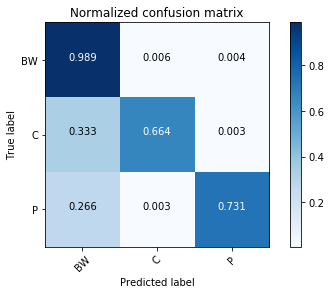

In [19]:
path2weights="./models/weights_smp_manet_320_effb5_cecv_01_last.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()
cfn_mx  = np.zeros((num_classes,num_classes), dtype=np.int64)
iou  = np.zeros((num_classes,len(masksList_test)))
dice = np.zeros((num_classes,len(masksList_test)))
hd   = np.zeros((num_classes,len(masksList_test)))
hd95 = np.zeros((num_classes,len(masksList_test)))
metric_history={ "miou": [], "mdice": [], "mhd": [], "mhd95": []}

m = 0
cci = np.zeros((1,num_classes))
cch = np.zeros((1,num_classes))
with torch.no_grad():
    for xb, yb in test_dl:
        yb=yb.cpu()
        output = model(xb.to(device))
        output = output.cpu() 
        pred = F.softmax(output,dim=1)
        preds = torch.argmax(pred, 1)
        cfn_matrix = confusion_matrix(yb.view(-1), preds.view(-1), labels=[0,1,2])
        cfn_mx += cfn_matrix 
        for i in range(len(preds)):
            gt = F.one_hot(yb[i],num_classes=3).permute(2,0,1).contiguous()
            pd = F.one_hot(preds[i],num_classes=3).permute(2,0,1).contiguous()
            cc = 0
            hh = 0
            for j in range(num_classes):
                iou[j,m], dice[j,m], hd[j,m], hd95[j,m], ci, ch = calculate_metric_percase(np.array(pd[j]), np.array(gt[j]))
                cc += ci 
                hh += ch
                cci[0,j] += ci
                cch[0,j] += ch
            metric_history["miou"].append(np.sum(iou[:,m])/cc)
            metric_history["mdice"].append(np.sum(dice[:,m])/cc)
            metric_history["mhd"].append(np.sum(hd[:,m])/hh)
            metric_history["mhd95"].append(np.sum(hd95[:,m])/hh) 
            m = m + 1;
            
print("Metrics (x image)")
print("IoU  : (%.4f, %.4f, %.4f)" % (np.sum(iou[0,:])/cci[0,0], np.sum(iou[1,:])/cci[0,1], np.sum(iou[2,:])/cci[0,2]))
print("Dice : (%.4f, %.4f, %.4f)" % (np.sum(dice[0,:])/cci[0,0], np.sum(dice[1,:])/cci[0,1], np.sum(dice[2,:])/cci[0,2]))
print("HD   : (%.4f, %.4f, %.4f)" % (np.sum(hd[0,:])/cch[0,0], np.sum(hd[1,:])/cch[0,1], np.sum(hd[2,:])/cch[0,2]))
print("HD95 : (%.4f, %.4f, %.4f)" % (np.sum(hd95[0,:])/cch[0,0], np.sum(hd95[1,:])/cch[0,1], np.sum(hd95[2,:])/cch[0,2]))
print("Global metrics (x image)")
print("mIoU  : %.4f" % (sum(metric_history["miou"])/m))
print("mDice : %.4f" % (sum(metric_history["mdice"])/m))
print("mHD   : %.4f" % (sum(metric_history["mhd"])/m))
print("mHD95 : %.4f" % (sum(metric_history["mhd95"])/m))
                        
label_names = ['BW','C','P']
plot_confusion_matrix(cfn_mx,classes=label_names,normalize=True)

In [20]:
print("Min(mIoU): (%.0f, %.6f)" % (metric_history["miou"].index(min(metric_history["miou"])), min(metric_history["miou"]))) 
print("Max(mIoU): (%.0f, %.6f)" % (metric_history["miou"].index(max(metric_history["miou"])), max(metric_history["miou"]))) 

Min(mIoU): (389, 0.361582)
Max(mIoU): (470, 0.964076)


mIoU  : 0.3616
mDice : 0.5308
mHD   : 133.8917
mHD95 : 99.5829


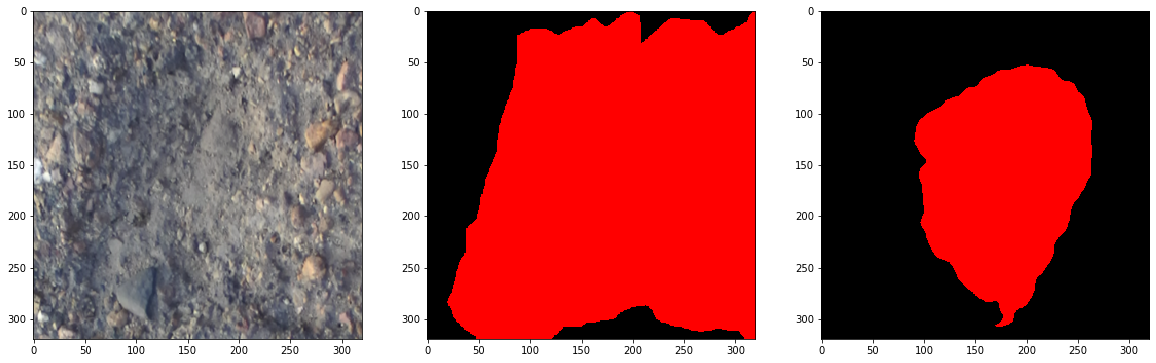

In [25]:
i=0
with torch.no_grad():
    for xb, yb in test_dl:
        yb=yb.cpu()
        output = model(xb.to(device))
        output = output.cpu() 
        pred = F.softmax(output,dim=1)
        preds = torch.argmax(pred, 1)
        i=i+1
        if i==7:
            break
            
n=17 # 389 = 62*(7-1)+17
print("mIoU  : %.4f" % metric_history["miou"][62*(i-1)+n])
print("mDice : %.4f" % metric_history["mdice"][62*(i-1)+n])
print("mHD   : %.4f"% metric_history["mhd"][62*(i-1)+n])
print("mHD95 : %.4f"% metric_history["mhd95"][62*(i-1)+n])
plt.figure(figsize=(20,20))

img, mask = xb[n], preds[n]

img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
show_target(yb[n])

plt.subplot(1, 3, 3) 
show_target(mask)

mIoU  : 0.9641
mDice : 0.9814
mHD   : 5.3852
mHD95 : 1.9142


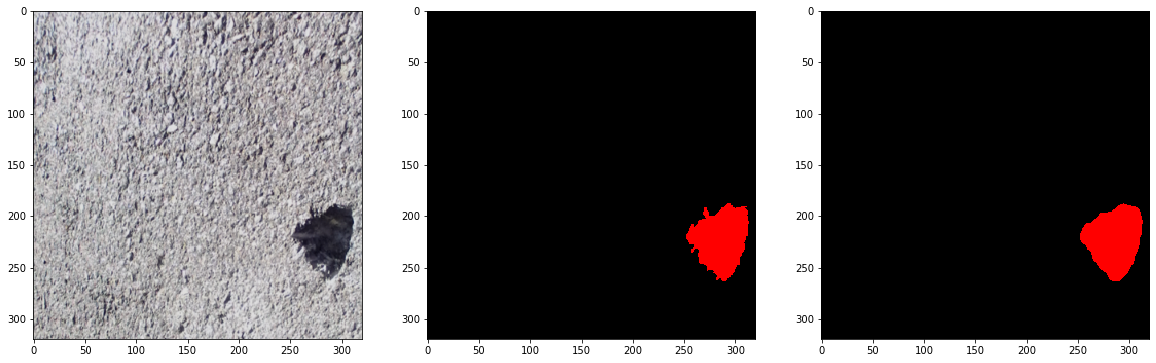

In [27]:
i=0
with torch.no_grad():
    for xb, yb in test_dl:
        yb=yb.cpu()
        output = model(xb.to(device))
        output = output.cpu() 
        pred = F.softmax(output,dim=1)
        preds = torch.argmax(pred, 1)
        i=i+1
        if i==8:
            break
            
n=36 # 470 = 62*(8-1)+36
print("mIoU  : %.4f" % metric_history["miou"][62*(i-1)+n])
print("mDice : %.4f" % metric_history["mdice"][62*(i-1)+n])
print("mHD   : %.4f"% metric_history["mhd"][62*(i-1)+n])
print("mHD95 : %.4f"% metric_history["mhd95"][62*(i-1)+n])
plt.figure(figsize=(20,20))

img, mask = xb[n], preds[n]

img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
show_target(yb[n])

plt.subplot(1, 3, 3) 
show_target(mask)